In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from skimage.color import rgb2lab

In [ ]:
# Determine device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Function to convert RGB images to L, a, and b channels in Lab color space
def rgb_to_lab(images):
    l_channels = []
    ab_channels = []
    for img in images:
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and move to CPU
        lab_image = rgb2lab(img)  # Convert to CIE-Lab

        # Normalize L, a, and b channels
        L_channel = lab_image[:, :, 0] / 100.0  # Normalize L channel to [0, 1]
        a_channel = (lab_image[:, :, 1] + 128) / 255.0  # Normalize a channel to [0, 1]
        b_channel = (lab_image[:, :, 2] + 128) / 255.0  # Normalize b channel to [0, 1]

        l_channels.append(L_channel)
        ab_channels.append(np.stack((a_channel, b_channel), axis=-1))  # Stack a and b

    # Convert to PyTorch tensors
    L = torch.tensor(np.stack(l_channels), dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, H, W)
    ab = torch.tensor(np.stack(ab_channels), dtype=torch.float32).permute(0, 3, 1, 2).to(device)  # (N, 2, H, W)
    return L, ab

In [ ]:
# CIFAR10 Dataset Loader
def load_cifar10_dataset(batch_size=8, num_workers=2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match ResNet/DenseNet input size
        transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    ])

    # Load the CIFAR-10 dataset
    train_set = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)

    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
# Define the colorization model
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Pre-trained ResNet50 encoder (modified to accept 1 channel input)
        self.encoder_resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.encoder_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_resnet = nn.Sequential(*list(self.encoder_resnet.children())[:-2])  # Remove the fully connected layer

        # Pre-trained DenseNet121 encoder (modified to accept 1 channel input)
        self.encoder_densenet = models.densenet121(weights='IMAGENET1K_V1')
        self.encoder_densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_densenet = nn.Sequential(*list(self.encoder_densenet.children())[:-1])  # Use all layers except the classifier

        # Pooling layer to downsample DenseNet output to 7x7
        self.downsample_densenet = nn.AdaptiveAvgPool2d((7, 7))

        # Fusion Blocks
        self.fusion_block1 = nn.Sequential(
            nn.Conv2d(2048 + 1024, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block2 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fusion_block4 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Decoder Blocks
        self.decoder_block1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

        self.decoder_block5 = nn.Sequential(
            nn.Conv2d(256, 2, kernel_size=3, padding=1),
            nn.Tanh(),  # Use Tanh to match output range [-1, 1]
            nn.Upsample(scale_factor=2)  # Upsample to 224 x 224
        )

    def forward(self, x):
        # Encoder
        x_resnet = self.encoder_resnet(x)  # ResNet output
        x_densenet = self.encoder_densenet(x)  # DenseNet output
        x_densenet = self.downsample_densenet(x_densenet)  # Downsample DenseNet output

        # Fusion Blocks
        fb1_input = torch.cat([x_resnet, x_densenet], dim=1)  # 2048 + 1024
        fb1_output = self.fusion_block1(fb1_input)

        fb2_input = torch.cat([fb1_output, fb1_output], dim=1)  # Use previous output only
        fb2_output = self.fusion_block2(fb2_input)

        fb3_input = torch.cat([fb2_output, fb2_output], dim=1)  # Use previous output only
        fb3_output = self.fusion_block3(fb3_input)

        fb4_input = torch.cat([fb3_output, fb3_output], dim=1)  # Use previous output only
        fb4_output = self.fusion_block4(fb4_input)

        # Decoder
        db1_output = self.decoder_block1(fb4_output)
        db2_output = self.decoder_block2(db1_output)
        db3_output = self.decoder_block3(db2_output)
        db4_output = self.decoder_block4(db3_output)

        output = self.decoder_block5(db4_output)

        return output

In [ ]:
import torch.nn.functional as F

# Training loop
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(train_loader):
            images = batch[0].to(device)  # Move images to device

            # Convert RGB to L and ab channels
            L, ab_target = rgb_to_lab(images)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass: model predicts 'a' and 'b' channels from 'L' channel
            ab_pred = model(L)  # The input is now just the L channel

            # Compute loss between predicted ab channels and ground truth ab channels
            loss = criterion(ab_pred, ab_target)
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Print loss every 500 batches
            if batch_idx % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [ ]:
# Example usage
if __name__ == "__main__":
    # Load the CIFAR10 dataset
    batch_size = 8
    train_loader, test_loader = load_cifar10_dataset(batch_size=batch_size)

    # Initialize the model
    model = ColorizationModel().to(device)  # Move model to GPU if available

    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Loss for comparing predicted ab with ground truth ab
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train the model
    num_epochs = 2
    train(model, train_loader, criterion, optimizer, num_epochs)

100%|██████████| 170498071/170498071 [00:03<00:00, 48920278.55it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 96.0MB/s]


Epoch [1/2], Batch [0/6250], Loss: 0.5466
Epoch [1/2], Batch [500/6250], Loss: 0.0054
Epoch [1/2], Batch [1000/6250], Loss: 0.0030
Epoch [1/2], Batch [1500/6250], Loss: 0.0014
Epoch [1/2], Batch [2000/6250], Loss: 0.0032
Epoch [1/2], Batch [2500/6250], Loss: 0.0034
Epoch [1/2], Batch [3000/6250], Loss: 0.0042
Epoch [1/2], Batch [3500/6250], Loss: 0.0016
Epoch [1/2], Batch [4000/6250], Loss: 0.0051
Epoch [1/2], Batch [4500/6250], Loss: 0.0030
Epoch [1/2], Batch [5000/6250], Loss: 0.0025
Epoch [1/2], Batch [5500/6250], Loss: 0.0013
Epoch [1/2], Batch [6000/6250], Loss: 0.0021
Epoch [2/2], Batch [0/6250], Loss: 0.0022
Epoch [2/2], Batch [500/6250], Loss: 0.0014
Epoch [2/2], Batch [1000/6250], Loss: 0.0019
Epoch [2/2], Batch [1500/6250], Loss: 0.0024
Epoch [2/2], Batch [2000/6250], Loss: 0.0024
Epoch [2/2], Batch [2500/6250], Loss: 0.0019
Epoch [2/2], Batch [3000/6250], Loss: 0.0045
Epoch [2/2], Batch [3500/6250], Loss: 0.0028
Epoch [2/2], Batch [4000/6250], Loss: 0.0056
Epoch [2/2], Batch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import lab2rgb

# Function to convert predicted 'L' and 'ab' channels to an RGB image
def lab_to_rgb(L, ab):
    L = L * 100  # Denormalize L channel from [0, 1] to [0, 100]
    ab = ab * 255 - 128  # Denormalize ab channels from [0, 1] to [-128, 128]

    lab = np.concatenate((L, ab), axis=2)  # Combine L and ab channels
    rgb_img = lab2rgb(lab)  # Convert Lab to RGB
    return rgb_img

In [ ]:
import matplotlib.pyplot as plt
from skimage.color import lab2rgb

def visualize_colorization(model, test_loader, num_images=4):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for batch in test_loader:
            images = batch[0].to(device)  # Get the original RGB images
            print(f"Original RGB Images Shape: {images.shape}")  # Debugging statement

            # Get the L and ab channels
            L, ab = rgb_to_lab(images)
            print(f"L Channel Shape: {L.shape}, ab Shape: {ab.shape}")  # Debugging statement

            # L already has shape (N, 1, H, W)
            # No need to change L

            # Predict ab channels from L
            ab_pred = model(L)  # Forward pass with L channel
            print(f"Predicted ab Shape: {ab_pred.shape}")  # Debugging statement

            # Convert the first few images to numpy for visualization
            for i in range(num_images):
                # Prepare the original RGB image
                original_rgb = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
                print(f"Original RGB Image Shape: {original_rgb.shape}")  # Debugging statement

                # Prepare the L channel
                L_cpu = L[i].cpu().numpy().squeeze() * 100  # Squeeze to (H, W) and denormalize to [0, 100]
                print(f"L Channel Shape After Squeeze: {L_cpu.shape}")  # Debugging statement

                # Prepare the predicted ab channel
                ab_cpu_pred = ab_pred[i].cpu().numpy() * 255 - 128  # Denormalize predicted ab channels
                print(f"Predicted ab Channel Shape: {ab_cpu_pred.shape}")  # Debugging statement

                # Reshape ab_cpu_pred to (224, 224, 2)
                ab_cpu_pred_reshaped = ab_cpu_pred.transpose(1, 2, 0)  # Change shape to (224, 224, 2)
                print(f"Reshaped Predicted ab Channel Shape: {ab_cpu_pred_reshaped.shape}")  # Debugging statement

                # Create LAB image and convert to RGB
                lab_image = np.concatenate((L_cpu[:, :, np.newaxis], ab_cpu_pred_reshaped), axis=2)  # Concatenate L and ab
                print(f"LAB Image Shape: {lab_image.shape}")  # Debugging statement

                rgb_colorized = lab2rgb(lab_image)  # Convert LAB back to RGB

                # Plot the images
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 3, 1)
                plt.title('Original RGB Image')
                plt.imshow(original_rgb.astype(np.uint8))
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title('L Channel')
                plt.imshow(L_cpu, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title('Colorized Image')
                plt.imshow(rgb_colorized)
                plt.axis('off')

                plt.show()

            break  # Remove this if you want to visualize more than one batch


Original RGB Images Shape: torch.Size([8, 3, 224, 224])
L Channel Shape: torch.Size([8, 1, 224, 224]), ab Shape: torch.Size([8, 2, 224, 224])
Predicted ab Shape: torch.Size([8, 2, 224, 224])
Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


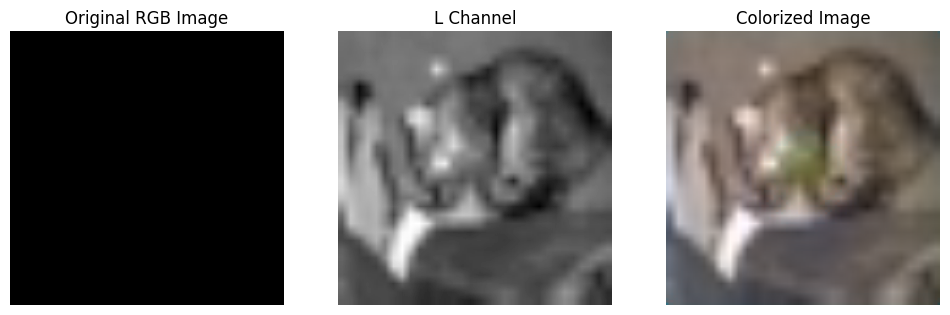

Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


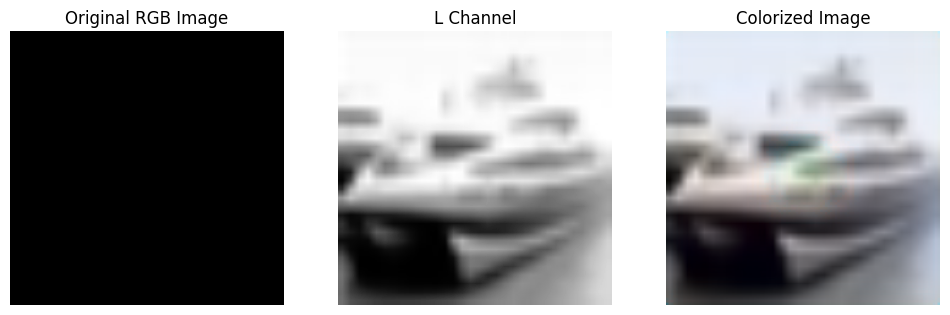

Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


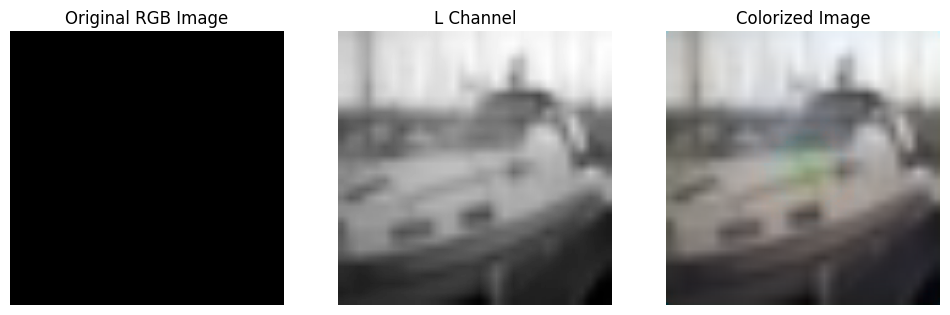

Original RGB Image Shape: (224, 224, 3)
L Channel Shape After Squeeze: (224, 224)
Predicted ab Channel Shape: (2, 224, 224)
Reshaped Predicted ab Channel Shape: (224, 224, 2)
LAB Image Shape: (224, 224, 3)


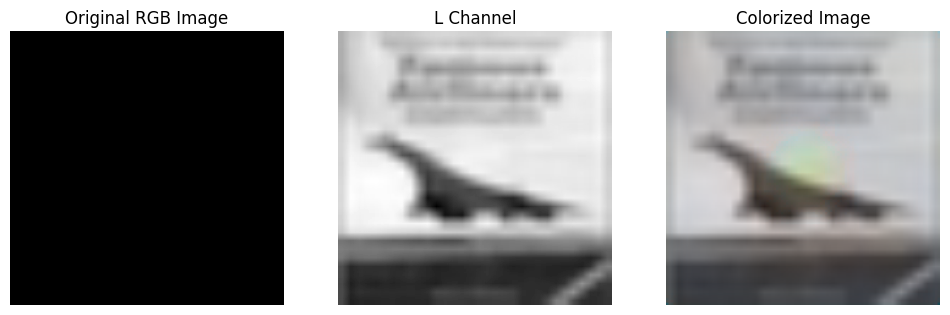

In [ ]:
# Testing and visualization
if __name__ == "__main__":
    # Visualize the model's colorization results with original images
    visualize_colorization(model, test_loader, num_images=4)

In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 10.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import torchmetrics
psnr = torchmetrics.functional.peak_signal_noise_ratio
ssim = torchmetrics.functional.structural_similarity_index_measure
import lpips  # For computing LPIPS

# Initialize LPIPS loss (AlexNet backbone for comparison)
lpips_loss_fn = lpips.LPIPS(net='alex').to(device)

ModuleNotFoundError: No module named 'lpips'

In [ ]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    mse_loss_fn = torch.nn.MSELoss()  # MSE loss for evaluation
    total_loss, total_mse, total_psnr, total_ssim, total_lpips = 0.0, 0.0, 0.0, 0.0, 0.0
    num_images = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in test_loader:
            images = batch[0].to(device)  # Get the original RGB images

            # Convert RGB to L and ab channels
            L, ab = rgb_to_ab(images)
            L = L.unsqueeze(1)  # Add channel dimension to L (Nx1xHxW)

            # Predict ab channels from L
            ab_pred = model(L)

            # Resize ground truth ab to match ab_pred size
            ab_resized = F.interpolate(ab.unsqueeze(1), size=ab_pred.shape[2:], mode='bilinear', align_corners=False)

            # Compute loss (MSE between predicted and ground truth ab channels)
            loss = mse_loss_fn(ab_pred, ab_resized)
            total_loss += loss.item()

            # Compute MSE for evaluation
            mse = F.mse_loss(ab_pred, ab_resized)
            total_mse += mse.item()

            # Convert to numpy for PSNR, SSIM, and LPIPS evaluation
            L_cpu = L.squeeze(1).cpu().numpy() * 100  # Denormalize L from [0, 1] to [0, 100]
            ab_cpu_gt = ab.cpu().numpy() * 255 - 128  # Denormalize ab from [0, 1] to [-128, 128]
            ab_cpu_pred = ab_pred.cpu().numpy() * 255 - 128  # Denormalize predicted ab

            for i in range(L.shape[0]):  # Loop over batch images
                # Reconstruct ground truth and predicted LAB images
                lab_gt = np.concatenate([L_cpu[i][:, :, np.newaxis], ab_cpu_gt[i]], axis=2)
                lab_pred = np.concatenate([L_cpu[i][:, :, np.newaxis], ab_cpu_pred[i]], axis=2)

                # Convert Lab to RGB
                rgb_gt = lab2rgb(lab_gt)
                rgb_pred = lab2rgb(lab_pred)

                # Compute PSNR
                psnr_value = psnr(torch.tensor(rgb_pred).permute(2, 0, 1).unsqueeze(0),
                                  torch.tensor(rgb_gt).permute(2, 0, 1).unsqueeze(0), data_range=1.0)
                total_psnr += psnr_value.item()

                # Compute SSIM
                ssim_value = ssim(torch.tensor(rgb_pred).permute(2, 0, 1).unsqueeze(0),
                                  torch.tensor(rgb_gt).permute(2, 0, 1).unsqueeze(0), data_range=1.0)
                total_ssim += ssim_value.item()

                # Compute LPIPS
                lpips_value = lpips_loss_fn(torch.tensor(rgb_pred).permute(2, 0, 1).unsqueeze(0).to(device),
                                            torch.tensor(rgb_gt).permute(2, 0, 1).unsqueeze(0).to(device))
                total_lpips += lpips_value.item()

                num_images += 1  # Track number of evaluated images

    # Calculate averages
    avg_loss = total_loss / len(test_loader)
    avg_mse = total_mse / num_images
    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images
    avg_lpips = total_lpips / num_images

    return avg_loss, avg_mse, avg_psnr, avg_ssim, avg_lpips


In [ ]:
# Example usage
if __name__ == "__main__":
    # Evaluate the model and print results
    avg_loss, avg_mse, avg_psnr, avg_ssim, avg_lpips = evaluate_model(model, test_loader)
    print(f"Average Test Loss: {avg_loss:.4f}")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average LPIPS: {avg_lpips:.4f}")

In [ ]:
import torch

# After training is complete
model_save_path = "colorization_model_cat.pth"

# Save the model's state_dict (recommended way to save models in PyTorch)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to colorization_model_cat.pth
